# Bayesian Hierarchical Stacking: Well Switching Case Study

 <figure>
  <img src="https://i.imgur.com/CiUmZKx.jpeg" alt="centered image" width="700px"/>
  <figcaption>Photo by Belinda Fewings, https://unsplash.com/photos/6p-KtXCBGNw.</figcaption>
</figure> 

### Table of Contents

* [Intro](#intro)
* [1. Exploratory Data Analysis](#1)
* [2. Prepare 6 Different Models](#2)
    * [2.1 Feature Engineering](#2.1)
    * [2.2 Training](#2.2)
* [3. Bayesian Hierarchical Stacking](#3)
    * [3.1 Prepare stacking datasets](#3.1)
    * [3.2 Define stacking model](#3.2)
* [4. Evaluate on test set](#4)
    * [4.1 Stack predictions](#4.1)
    * [4.2 Compare methods](#4.2)
* [Conclusion](#conclusion)
* [References](#references)

## Intro <a class="anchor" id="1"></a>

Suppose you have just fit 6 models to a dataset, and need to choose which one to use to make predictions on your test set. How do you choose which one to use? A couple of common tactics are:
- choose the best model based on cross-validation;
- average the models, using weights based on cross-validation scores.

In the paper _Bayesian hierarchical stacking: Some models are (somewhere) useful_ [[1](#References)], a new technique is introduced: average models based on weights which are allowed to vary across according to the input data, based on a hierarchical structure.


Here, we'll implement the first case study from that paper - readers are nonetheless encouraged to look at the original paper to find other cases studies, as well as theoretical results. Code from the article (in R / Stan) can be found _here_ [[3](#References)].

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpyro
import jax
import scipy
import scipy.stats as stats
import seaborn as sns
from scipy.interpolate import BSpline

plt.style.use("seaborn")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)
assert numpyro.__version__.startswith("0.7.2")

In [3]:
%matplotlib inline

## 1. Exploratory Data Analysis <a class="anchor" id="1"></a>

The data we have to work with looks at households in Bangladesh, some of which were affected by high levels of arsenic in their water. Would affected households want to switch to a neighbour's well?

We'll split the data into a train and test set, and then we'll train six different models to try to predict whether households would switch wells. Then, we'll see how we can stack them when predicting on the test set!

But first, let's load it in and visualise it! Each row represents a household, and the features we have available to us are:

- switch: whether a household switched to another well;
- arsenic: level of arsenic in drinking water;
- educ: level of education of "head of household";
- dist100: distance to nearest safe-drinking well;
- assoc: whether the household participates in any community activities.

In [4]:
wells = pd.read_csv(
    "http://stat.columbia.edu/~gelman/arm/examples/arsenic/wells.dat", sep=" "
)

In [5]:
wells.head()

,switch,arsenic,dist,assoc,educ
1,1,2.36,16.826000,0,0
2,1,0.71,47.321999,0,0
3,0,2.07,20.966999,0,10
4,1,1.15,21.486000,0,12
5,1,1.10,40.874001,1,14


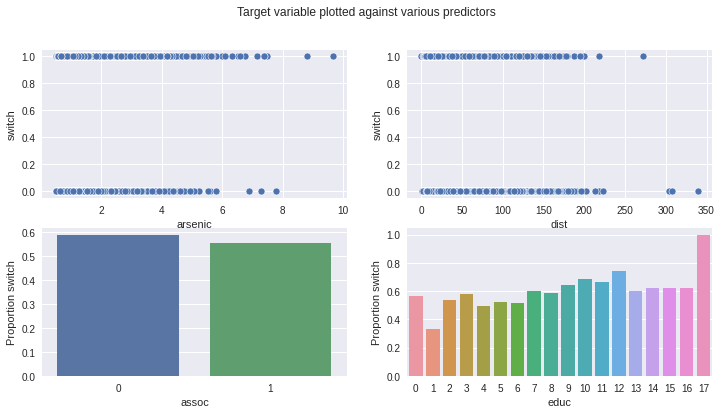

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle("Target variable plotted against various predictors")
sns.scatterplot(data=wells, x="arsenic", y="switch", ax=ax[0][0])
sns.scatterplot(data=wells, x="dist", y="switch", ax=ax[0][1])
sns.barplot(
    data=wells.groupby("assoc")["switch"].mean().reset_index(),
    x="assoc",
    y="switch",
    ax=ax[1][0],
)
ax[1][0].set_ylabel("Proportion switch")
sns.barplot(
    data=wells.groupby("educ")["switch"].mean().reset_index(),
    x="educ",
    y="switch",
    ax=ax[1][1],
)
ax[1][1].set_ylabel("Proportion switch");

Next, we'll choose 200 observations to be part of our train set, and 1500 to be part of our test set.

In [7]:
np.random.seed(1)
train_id = wells.sample(n=200).index
test_id = wells.loc[~wells.index.isin(train_id)].sample(n=1500).index
y_train = wells.loc[train_id, "switch"].to_numpy()
y_test = wells.loc[test_id, "switch"].to_numpy()

## 2. Prepare 6 different candidate models <a class="anchor" id="2"></a>

### 2.1 Feature Engineering <a class="anchor" id="2.1"></a>

First, let's add a few new columns:
- `edu0`: whether `educ` is `0`,
- `edu1`: whether `educ` is between `1` and `5`,
- `edu2`: whether `educ` is between `6` and `11`,
- `edu3`: whether `educ` is between `12` and `17`,
- `logarsenic`: natural logarithm of `arsenic`,
- `assoc_half`: half of `assoc`,
- `as_square`: natural logarithm of `arsenic`, squared,
- `as_third`: natural logarithm of `arsenic`, cubed,
- `dist100`: `dist` divided by `100`,
 - `intercept`: just a columns of `1`s.

We're going to start by fitting 6 different models to our train set:

- logistic regression using `intercept`, `arsenic`, `assoc`, `edu1`, `edu2`, and `edu3`;
- same as above, but with `logarsenic` instead of `arsenic`;
- same as the first one, but with square and cubic features as well;
- same as the first one, but with spline features derived from `logarsenic` as well;
- same as the first one, but with spline features derived from `dist100` as well;
- same as the first one, but with `educ` instead of the binary `edu` variables.

In [8]:
wells["edu0"] = wells["educ"].isin(np.arange(0, 1)).astype(int)
wells["edu1"] = wells["educ"].isin(np.arange(1, 6)).astype(int)
wells["edu2"] = wells["educ"].isin(np.arange(6, 12)).astype(int)
wells["edu3"] = wells["educ"].isin(np.arange(12, 18)).astype(int)
wells["logarsenic"] = np.log(wells["arsenic"])
wells["assoc_half"] = wells["assoc"] / 2.0
wells["as_square"] = wells["logarsenic"] ** 2
wells["as_third"] = wells["logarsenic"] ** 3
wells["dist100"] = wells["dist"] / 100.0
wells["intercept"] = 1

In [9]:
def bs(x, knots, degree):
    """Replicates ``bs`` from splines package in R."""
    padded_knots = np.hstack(
        [[x.min()] * (degree + 1), knots, [x.max()] * (degree + 1)]
    )
    return pd.DataFrame(
        BSpline(padded_knots, np.eye(len(padded_knots) - degree - 1), degree)(x)[:, 1:],
        index=x.index,
    )


knots = np.quantile(wells.loc[train_id, "logarsenic"], np.linspace(0.1, 0.9, num=10))
spline_arsenic = bs(wells["logarsenic"], knots=knots, degree=3)
knots = np.quantile(wells.loc[train_id, "dist100"], np.linspace(0.1, 0.9, num=10))
spline_dist = bs(wells["dist100"], knots=knots, degree=3)

In [10]:
features_0 = ["intercept", "dist100", "arsenic", "assoc", "edu1", "edu2", "edu3"]
features_1 = ["intercept", "dist100", "logarsenic", "assoc", "edu1", "edu2", "edu3"]
features_2 = [
    "intercept",
    "dist100",
    "arsenic",
    "as_third",
    "as_square",
    "assoc",
    "edu1",
    "edu2",
    "edu3",
]
features_3 = ["intercept", "dist100", "assoc", "edu1", "edu2", "edu3"]
features_4 = ["intercept", "logarsenic", "assoc", "edu1", "edu2", "edu3"]
features_5 = ["intercept", "dist100", "logarsenic", "assoc", "educ"]

X0 = wells.loc[train_id, features_0].to_numpy()
X1 = wells.loc[train_id, features_1].to_numpy()
X2 = wells.loc[train_id, features_2].to_numpy()
X3 = (
    pd.concat([wells.loc[:, features_3], spline_arsenic], axis=1)
    .loc[train_id]
    .to_numpy()
)
X4 = pd.concat([wells.loc[:, features_4], spline_dist], axis=1).loc[train_id].to_numpy()
X5 = wells.loc[train_id, features_5].to_numpy()

X0_test = wells.loc[test_id, features_0].to_numpy()
X1_test = wells.loc[test_id, features_1].to_numpy()
X2_test = wells.loc[test_id, features_2].to_numpy()
X3_test = (
    pd.concat([wells.loc[:, features_3], spline_arsenic], axis=1)
    .loc[test_id]
    .to_numpy()
)
X4_test = (
    pd.concat([wells.loc[:, features_4], spline_dist], axis=1).loc[test_id].to_numpy()
)
X5_test = wells.loc[test_id, features_5].to_numpy()

In [11]:
train_x_list = [X0, X1, X2, X3, X4, X5]
test_x_list = [X0_test, X1_test, X2_test, X3_test, X4_test, X5_test]
K = len(train_x_list)

### 2.2 Training <a class="anchor" id="2.2"></a>

Each model will be trained in the same way - with a Bernoulli likelihood and a logit link function.

In [12]:
def logistic(x, y=None):
    beta = numpyro.sample(
        "beta", numpyro.distributions.Normal(0, 3), sample_shape=(x.shape[1],)
    )
    logits = numpyro.deterministic("logits", jax.numpy.matmul(x, beta))

    numpyro.sample(
        "obs",
        numpyro.distributions.Bernoulli(logits=logits),
        obs=y,
    )

In [13]:
fit_list = []
for k in range(K):
    sampler = numpyro.infer.NUTS(logistic)
    mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
    mcmc.run(
        jax.random.PRNGKey(0),
        x=train_x_list[k],
        y=y_train,
    )
    idata = az.from_numpyro(mcmc)
    fit_list.append(idata)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### 2.3 Estimate leave-one-out cross-validated score for each training point <a class="anchor" id="2.3"></a>

Rather than refitting each model 100 times, we will estimate the leave-one-out cross-validated score using _LOO_ [[2](#References)].

In [14]:
def find_point_wise_loo_score(fit):
    return az.loo(fit, pointwise=True, scale="log").loo_i.values


lpd_point = np.vstack([find_point_wise_loo_score(fit) for fit in fit_list]).T
exp_lpd_point = np.exp(lpd_point)

## 3. Bayesian Hierarchical Stacking <a class="anchor" id="3"></a>

### 3.1 Prepare stacking datasets <a class="anchor" id="3.1"></a>

To determine how the stacking weights should vary across training and test sets, we will need to create stacking datasets. For discrete features, this is easy, we just one-hot-encode them. But for continuous features, we need a trick. In Equation (16), the authors recommend the following: if you have a continuous feature `f`, then replace it with the following two features:

- `f_l`: `f` minus the median of `f`, clipped above at 0;
- `f_r`: `f` minus the median of `f`, clipped below at 0;

In [15]:
dist100_median = wells.loc[wells.index[train_id], "dist100"].median()
logarsenic_median = wells.loc[wells.index[train_id], "logarsenic"].median()
wells["dist100_l"] = (wells["dist100"] - dist100_median).clip(upper=0)
wells["dist100_r"] = (wells["dist100"] - dist100_median).clip(lower=0)
wells["logarsenic_l"] = (wells["logarsenic"] - logarsenic_median).clip(upper=0)
wells["logarsenic_r"] = (wells["logarsenic"] - logarsenic_median).clip(lower=0)

stacking_features = [
    "edu0",
    "edu1",
    "edu2",
    "edu3",
    "assoc_half",
    "dist100_l",
    "dist100_r",
    "logarsenic_l",
    "logarsenic_r",
]
X_stacking_train = wells.loc[train_id, stacking_features].to_numpy()
X_stacking_test = wells.loc[test_id, stacking_features].to_numpy()

### 3.2 Define stacking model

What we seek to find is a matrix of weights $W$ with which to multiply the models' predictions. Let's define a matrix $Pred$ such that $Pred_{i, k}$ represents the prediction made for point $i$ by model $k$. Then the final prediction for point $i$ will then be:

$$ \sum_k W_{i, k}Pred_{i, k} $$

Such a matrix $W$ would be required to have each column sum to $1$. Hence, we calculate each row $W_i$ of $W$ as:

$$ W_i = \text{softmax}(X\text{_stacking}_i \cdot \beta), $$

where $\beta$ is a matrix whose values we seek to determine. For the discrete features, $\beta$ is given a hierarchical structure over the possible inputs. Continuous features, on the other hand, get no hierarchical structure and just vary according to the input values.

Notice how, for the discrete features, a non-centered parametrisation is used [[4](#References)] . Also note that we only need to estimate `K-1` columns of $\beta$, because the weights `W_{i, k}` will have to sum to `1` for each `i`.

In [16]:
def stacking(
    X,
    d_discrete,
    X_test,
    exp_lpd_point,
    tau_mu,
    tau_sigma,
):
    N = X.shape[0]
    d = X.shape[1]
    N_test = X_test.shape[0]
    K = lpd_point.shape[1]

    beta_con = numpyro.sample(
        "beta_con",
        numpyro.distributions.Normal(0, 1),
        sample_shape=(K - 1, d - d_discrete),
    )
    tau = numpyro.sample(
        "tau", numpyro.distributions.Normal(0, 1), sample_shape=(K - 1, d_discrete)
    )

    mu = numpyro.sample(
        "mu",
        numpyro.distributions.Normal(0, tau_mu),
        sample_shape=(K - 1,),
    )
    sigma = numpyro.sample(
        "sigma",
        numpyro.distributions.TruncatedNormal(low=0, loc=0, scale=tau_sigma),
        sample_shape=(K - 1,),
    )

    beta = numpyro.deterministic(
        "beta",
        jax.numpy.vstack(
            [
                jax.numpy.hstack([mu[k] + sigma[k] * tau[k], beta_con[k]])
                for k in range(K - 1)
            ],
        ),
    )
    assert beta.shape == (K - 1, d)

    f = jax.numpy.hstack(
        [
            jax.numpy.vstack(
                [jax.numpy.matmul(X, beta[k]) for k in range(K - 1)],
            ).T,
            jax.numpy.zeros((N, 1)),
        ]
    )
    assert f.shape == (N, K)

    w = numpyro.deterministic("w", jax.nn.softmax(f, axis=1))

    logp = jax.numpy.log((exp_lpd_point * w).sum(axis=1))
    assert logp.shape == (N,)

    numpyro.factor("logp", jax.numpy.sum(logp))

    f_test = jax.numpy.hstack(
        [
            jax.numpy.vstack(
                [jax.numpy.matmul(X_test, beta[k]) for k in range(K - 1)],
            ).T,
            jax.numpy.zeros((N_test, 1)),
        ]
    )
    w_test = numpyro.deterministic("w_test", jax.nn.softmax(f_test, axis=1))
    numpyro.deterministic(
        "w_test",
        w_test,
    )

In [17]:
sampler = numpyro.infer.NUTS(stacking)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    X=X_stacking_train,
    d_discrete=4,
    X_test=X_stacking_test,
    exp_lpd_point=exp_lpd_point,
    tau_mu=1.0,
    tau_sigma=0.5,
)
idata = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We can now extract the weights with which to weight the different models from the posterior, and then visualise how they vary across the training set.

Let's compare them with what the weights would've been if we'd just used fixed stacking weights derived from the LOO scores. Notice how Bayesian Hierarchical Stacking induces a shrinkage effect - the weights are not allowed to vary too much from each model's mean weight.

In [18]:
w = idata.posterior.w.mean(dim=("chain", "draw"))

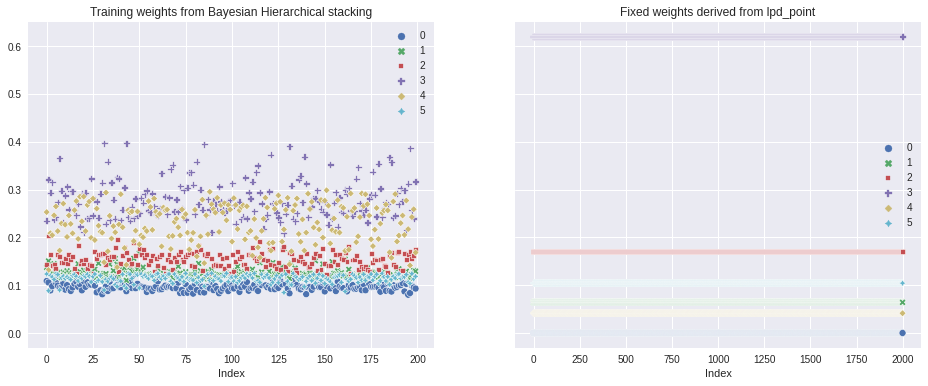

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
sns.scatterplot(data=pd.DataFrame(w.values), ax=ax[0])
sns.scatterplot(
    data=pd.DataFrame(
        np.hstack(
            [
                scipy.special.softmax(lpd_point.sum(axis=0))[:, np.newaxis]
                for _ in range(2000)
            ]
        ).T
    ),
    ax=ax[1],
)
ax[0].set_title("Training weights from Bayesian Hierarchical stacking")
ax[1].set_title("Fixed weights derived from lpd_point")
ax[0].set_xlabel("Index")
ax[1].set_xlabel("Index");

## 4. Evaluate on test set <a class="anchor" id="4"></a>

### 4.1 Stack predictions <a class="anchor" id="4.1"></a>

Now, for each model, let's evaluate the log predictive density for each point in the test set. Once we have predictions for each model, we need to think about how to combine them, such that for each test point, we get a single prediction.

We decided we'd do this in three ways:
- Bayesian Hierarchical Stacking (`bhs_pred`);
- choosing the model with the best training set LOO score (`model_selection_preds`);
- fixed-weights stacking based on LOO scores (`fixed_weights_preds`).

In [20]:
train_preds = []
for k in range(K):
    train_pred = scipy.special.expit(
        np.matmul(
            train_x_list[k],
            fit_list[k].posterior.beta.stack(samples=("chain", "draw")).values,
        )
    )
    train_preds.append(train_pred.mean(axis=1))
train_preds = np.vstack(train_preds).T

In [21]:
preds = []
for k in range(K):
    post_pred = scipy.special.expit(
        np.matmul(
            test_x_list[k],
            fit_list[k].posterior.beta.stack(samples=("chain", "draw")).values,
        )
    )
    preds.append(post_pred.mean(axis=1))
preds = np.vstack(preds).T

In [22]:
w_test = idata.posterior.w_test.mean(dim=("chain", "draw"))
bhs_predictions = (w_test * preds).sum(axis=1)
model_selection_preds = preds[:, lpd_point.sum(axis=0).argmax()]
fixed_weights_preds = (scipy.special.softmax(lpd_point.sum(axis=0)) * preds).sum(axis=1)

### 4.2 Compare methods <a class="anchor" id="4.2"></a>

Let's compare the log predictive density scores on the test set (note: higher is better):

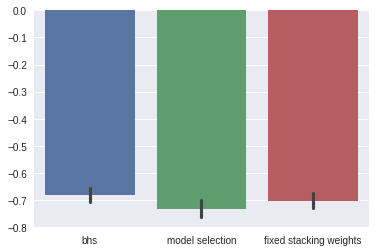

In [23]:
logpms = pd.DataFrame(
    np.vstack(
        [
            stats.bernoulli(p=bhs_predictions).logpmf(y_test),
            stats.bernoulli(p=model_selection_preds).logpmf(y_test),
            stats.bernoulli(p=fixed_weights_preds).logpmf(y_test),
        ]
    ).T,
    columns=["bhs", "model selection", "fixed stacking weights"],
)
sns.barplot(data=logpms);

In [24]:
logpms.describe()

,bhs,model selection,fixed stacking weights
count,1500.000000,1500.000000,1500.000000
mean,-0.682228,-0.733399,-0.702528
std,0.500419,0.617741,0.550504
min,-3.173964,-3.606597,-3.302836
25%,-0.950703,-0.992178,-0.955311
50%,-0.533367,-0.546873,-0.536695
75%,-0.286636,-0.253105,-0.273047
max,-0.041472,-0.024854,-0.036058


So, in this dataset, with this particular train-test split, Bayesian Hierarchical Stacking does indeed bring a small gain compared with model selection and compared with fixed-weight stacking.

### 4.3 Does this prove that Bayesian Hierarchical Stacking works? <a class="anchor" id="4.3"></a>

No, a single train-test split doesn't prove anything. Check the original paper for results with varying training set sizes, repeated with different train-test splits, in which they show that Bayesian Hierarchical Stacking consistently outperforms model selection and fixed-weight stacking.

The goal of this notebook was just to show how to implement this technique in NumPyro.

## Conclusion <a class="anchor" id="conclusion"></a>

We've seen how Bayesian Hierarchical Stacking can help us average models with input-dependent weights, in a manner which doesn't overfit. We only implemented the first case study from the paper, but readers are encouraged to check out the other two as well. Also check the paper for theoretical results and results from more experiments.

## References

1. Yuling Yao, Gregor Pirš, Aki Vehtari, Andrew Gelman (2021). [Bayesian hierarchical stacking: Some models are (somewhere) useful](https://arxiv.org/abs/2101.08954)
2. Måns Magnusson, Michael Riis Andersen, Johan Jonasson, Aki Vehtari (2020). [Leave-One-Out Cross-Validation for Bayesian Model Comparison in Large Data](https://arxiv.org/abs/2001.00980)
3. https://github.com/yao-yl/hierarchical-stacking-code.
4. Thomas Wiecki (2017). [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)